In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Loading in hourly rain data from CSV, parsing the timestamp, and adding it as an index so it's more useful

rain_df = pd.read_csv('data/chicago_rain_hourly.csv')
rain_df['DateTime'] = pd.to_datetime(rain_df['DateTime'])
rain_df = rain_df.set_index(pd.DatetimeIndex(rain_df['DateTime']))
print(rain_df.dtypes)
rain_df.head()

DateTime        datetime64[ns]
STATION                 object
STATION_NAME            object
DATE                    object
HOURLYPrecip           float64
DAILYPrecip            float64
dtype: object


,DateTime,STATION,STATION_NAME,DATE,HOURLYPrecip,DAILYPrecip
2013-08-01 00:51:00,2013-08-01 00:51:00,WBAN:94846,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-08-01 00:51:00,0.0,0.0
2013-08-01 01:51:00,2013-08-01 01:51:00,WBAN:94846,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-08-01 01:51:00,0.0,0.0
2013-08-01 02:51:00,2013-08-01 02:51:00,WBAN:94846,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-08-01 02:51:00,0.0,0.0
2013-08-01 03:51:00,2013-08-01 03:51:00,WBAN:94846,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-08-01 03:51:00,0.0,0.0
2013-08-01 04:51:00,2013-08-01 04:51:00,WBAN:94846,CHICAGO OHARE INTERNATIONAL AIRPORT IL US,2013-08-01 04:51:00,0.0,0.0


In [3]:
# Resampling the dataframe into one hour increments, accessing max because accumulation listed more often than hourly (i.e. 
# every 15 minutes) is the total precipitation since the hour began
# Description: http://www1.ncdc.noaa.gov/pub/data/cdo/documentation/LCD_documentation.pdf

chi_rain_series = rain_df['HOURLYPrecip'].resample('1H').max()
print(chi_rain_series.count())
chi_rain_series.head()

26615


2013-08-01 00:00:00    0.0
2013-08-01 01:00:00    0.0
2013-08-01 02:00:00    0.0
2013-08-01 03:00:00    0.0
2013-08-01 04:00:00    0.0
Freq: H, Name: HOURLYPrecip, dtype: float64

### N-Year Metrics

Using rolling time series in pandas to find n-year events. First looking at some for 6 hour interval.

The rolling sum here calculates the sum of observations over a given number of observations over time. Since each observation here is an hour, the window we provide is a number of hours. Each row is then the sum of observations over that number of hours.

If we had the following rows:

* 1pm: 2
* 2pm: 3
* 3pm: 1
* 4pm: 5

And we calculate the rolling sum with a window of 2 hours, the results will be:

* 1pm: NaN (because we only have one observation at this point)
* 2pm: 5
* 3pm: 4
* 4pm: 6

Details of the specific cutoffs for each level of n-year storm can be found here: [Rainfall Frequency Information Illinois](http://www.isws.illinois.edu/atmos/statecli/RF/rf.htm)

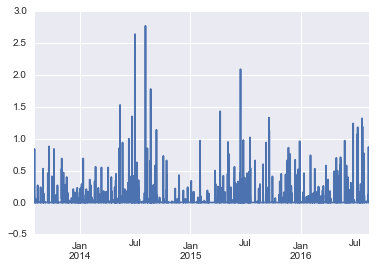

In [4]:
roll_6_hr = chi_rain_series.rolling(window=6)
roll_6_hr.sum().plot()

##### Notes on Initial Results 

Because it's looking for a count of intervals, the initial counts of events returned could include more than one event per storm. For example, if one storm lasted 8 hours from 1pm to 9pm and rained relatively consistently throughout at a 5-year event level and we're looking for 6 hour intervals, it could count for as many as 3 events.

In [5]:
roll_6 = pd.DataFrame(roll_6_hr.sum())

print('For 6-hour intervals')
print('{} 1-year events for Northeast Illinois'.format(len(roll_6[(roll_6['HOURLYPrecip'] >= 1.88) & 
                                                                  (roll_6['HOURLYPrecip'] < 2.28)])))
print('{} 2-year events for Northeast Illinois'.format(len(roll_6[(roll_6['HOURLYPrecip'] >= 2.28) &
                                                                  (roll_6['HOURLYPrecip'] < 2.85)])))
print('{} 5-year events for Northeast Illinois'.format(len(roll_6[(roll_6['HOURLYPrecip'] >= 2.85) &
                                                                  (roll_6['HOURLYPrecip'] < 3.35)])))
print('{} 10-year events for Northeast Illinois'.format(len(roll_6[(roll_6['HOURLYPrecip'] >= 3.35) &
                                                                   (roll_6['HOURLYPrecip'] < 4.13)])))
print('{} 25-year events for Northeast Illinois'.format(len(roll_6[(roll_6['HOURLYPrecip'] >= 4.13) & 
                                                                   (roll_6['HOURLYPrecip'] < 4.90)])))
print('{} 50-year events for Northeast Illinois'.format(len(roll_6[(roll_6['HOURLYPrecip'] >= 4.90) &
                                                                   (roll_6['HOURLYPrecip'] < 5.69)])))
print('{} 100-year events for Northeast Illinois'.format(len(roll_6[roll_6['HOURLYPrecip'] >= 5.69])))

For 6-hour intervals
4 1-year events for Northeast Illinois
8 2-year events for Northeast Illinois
0 5-year events for Northeast Illinois
0 10-year events for Northeast Illinois
0 25-year events for Northeast Illinois
0 50-year events for Northeast Illinois
0 100-year events for Northeast Illinois


In [6]:
roll_6_1yr = roll_6[(roll_6['HOURLYPrecip'] >= 1.88) & (roll_6['HOURLYPrecip'] < 2.28)]
print('{} days with 1-year events in Northeast Illinois'.format(len(roll_6_1yr.groupby(roll_6_1yr.index.date))))
roll_6_1yr

2 days with 1-year events in Northeast Illinois


,HOURLYPrecip
2014-08-04 19:00:00,2.21
2015-06-15 18:00:00,2.00
2015-06-15 19:00:00,2.07
2015-06-15 20:00:00,2.09


In [7]:
# Many of these are from the same days, but over slightly different intervals as mentioned before
roll_6_2yr = roll_6[(roll_6['HOURLYPrecip'] >= 2.28) & (roll_6['HOURLYPrecip'] < 2.85)]
print('{} days with 2-year events in Northeast Illinois'.format(len(roll_6_2yr.groupby(roll_6_2yr.index.date))))
roll_6_2yr

3 days with 2-year events in Northeast Illinois


,HOURLYPrecip
2014-06-30 21:00:00,2.50
2014-06-30 22:00:00,2.64
2014-06-30 23:00:00,2.28
2014-08-04 20:00:00,2.67
2014-08-04 21:00:00,2.69
2014-08-04 22:00:00,2.77
2014-08-04 23:00:00,2.77
2014-08-05 00:00:00,2.51


In [8]:
# Helper function taking the series, window, and list of cutoffs to make this quicker, returns the subset
def rolling_results(rain_series, window, rain_cutoffs):
    window_df = pd.DataFrame(rain_series.rolling(window=window).sum())
    print('For {}-hour intervals'.format(window))
    print('{} 1-year events for Northeast Illinois'.format(len(window_df[(window_df['HOURLYPrecip'] >= rain_cutoffs[0]) & 
                                                                         (window_df['HOURLYPrecip'] < rain_cutoffs[1])])))
    print('{} 2-year events for Northeast Illinois'.format(len(window_df[(window_df['HOURLYPrecip'] >= rain_cutoffs[1]) & 
                                                                         (window_df['HOURLYPrecip'] < rain_cutoffs[2])])))
    print('{} 5-year events for Northeast Illinois'.format(len(window_df[(window_df['HOURLYPrecip'] >= rain_cutoffs[2]) & 
                                                                         (window_df['HOURLYPrecip'] < rain_cutoffs[3])])))
    print('{} 10-year events for Northeast Illinois'.format(len(window_df[(window_df['HOURLYPrecip'] >= rain_cutoffs[3]) & 
                                                                         (window_df['HOURLYPrecip'] < rain_cutoffs[4])])))
    print('{} 25-year events for Northeast Illinois'.format(len(window_df[(window_df['HOURLYPrecip'] >= rain_cutoffs[4]) & 
                                                                          (window_df['HOURLYPrecip'] < rain_cutoffs[5])])))
    print('{} 50-year events for Northeast Illinois'.format(len(window_df[(window_df['HOURLYPrecip'] >= rain_cutoffs[5]) & 
                                                                          (window_df['HOURLYPrecip'] < rain_cutoffs[6])])))
    print('{} 100-year events for Northeast Illinois'.format(len(window_df[window_df['HOURLYPrecip'] >= rain_cutoffs[6]])))
    
# Gets the subset of the dataframe for the given cutoff index (i.e. 5 year is the third, so cutoff_index would be 3)
def rolling_subset(rain_series, window, rain_cutoffs, cutoff_index):
    window_df = pd.DataFrame(rain_series.rolling(window=window).sum())
    if cutoff_index <= 6:
        return window_df[(window_df['HOURLYPrecip'] >= rain_cutoffs[cutoff_index - 1]) & (roll_6['HOURLYPrecip'] < 2.85)]
    if cutoff_index == 7:
        return window_df[window_df['HOURLYPrecip'] >= rain_cutoffs[cutoff_index -1]]

In [9]:
cutoffs_12hr = [2.18, 2.64, 3.31, 3.89, 4.79, 5.6, 6.59]
rolling_results(chi_rain_series, 12, cutoffs_12hr)

For 12-hour intervals
10 1-year events for Northeast Illinois
18 2-year events for Northeast Illinois
0 5-year events for Northeast Illinois
0 10-year events for Northeast Illinois
0 25-year events for Northeast Illinois
0 50-year events for Northeast Illinois
0 100-year events for Northeast Illinois


In [10]:
roll_12_2yr = rolling_subset(chi_rain_series, 12, cutoffs_12hr, 2)
print('{} days with 2-year events for 12 hrs in Northeast Illinois'.format(len(roll_12_2yr.groupby(roll_12_2yr.index.date))))
roll_12_2yr

5 days with 2-year events for 12 hrs in Northeast Illinois


,HOURLYPrecip
2014-06-30 22:00:00,2.64
2014-06-30 23:00:00,2.68
2014-07-01 00:00:00,2.68
2014-07-01 01:00:00,2.68
2014-07-01 02:00:00,2.68
2014-07-01 03:00:00,2.68
2014-07-01 04:00:00,2.68
2014-08-04 20:00:00,2.67
2014-08-04 21:00:00,2.70
2014-08-04 22:00:00,2.78


In [11]:
cutoffs_24hr = [2.51, 3.04, 3.80, 4.47, 5.51, 6.46, 7.58]
rolling_results(chi_rain_series, 24, cutoffs_24hr)

For 24-hour intervals
61 1-year events for Northeast Illinois
0 2-year events for Northeast Illinois
0 5-year events for Northeast Illinois
0 10-year events for Northeast Illinois
0 25-year events for Northeast Illinois
0 50-year events for Northeast Illinois
0 100-year events for Northeast Illinois


In [12]:
roll_24_1yr = rolling_subset(chi_rain_series, 24, cutoffs_24hr, 1)
print('{} days with 1-year events for 24 hrs in Northeast Illinois'.format(len(roll_24_1yr.groupby(roll_24_1yr.index.date))))

7 days with 1-year events for 24 hrs in Northeast Illinois


In [13]:
cutoffs_48hr = [2.70, 3.30, 4.09, 4.81, 5.88, 6.84, 8.16]
rolling_results(chi_rain_series, 48, cutoffs_48hr)

For 48-hour intervals
150 1-year events for Northeast Illinois
7 2-year events for Northeast Illinois
0 5-year events for Northeast Illinois
0 10-year events for Northeast Illinois
0 25-year events for Northeast Illinois
0 50-year events for Northeast Illinois
0 100-year events for Northeast Illinois


In [14]:
roll_48_1yr = rolling_subset(chi_rain_series, 48, cutoffs_48hr, 1)
print('{} days with 1-year events for 48 hrs in Northeast Illinois'.format(len(roll_48_1yr.groupby(roll_48_1yr.index.date))))

13 days with 1-year events for 48 hrs in Northeast Illinois


**Note:** Because the rolling window pulls from the same overlapping period multiple times, it makes sense that longer time periods have higher amounts of events at the lower end of the spectrum. They're pulling from the same incidents more times than the shorter intervals can